In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
metadata=pd.read_csv('infy.csv')
df=metadata.copy()

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-03-11,0.583984,0.781250,0.583984,0.732422,0.496775,172512000
1,1999-03-12,0.734375,0.761719,0.671875,0.728516,0.494125,39897600
2,1999-03-15,0.730469,0.730469,0.658203,0.662109,0.449084,12672000
3,1999-03-16,0.667969,0.691406,0.656250,0.656250,0.445110,9984000
4,1999-03-17,0.656250,0.699219,0.652344,0.660156,0.447759,15449600


In [6]:
df = df[['Date', 'Close','Volume']]
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
df['Date']=df['Date'].apply(str_to_datetime)

C:\Users\tirth\AppData\Local\Temp\ipykernel_14128\1832879925.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']=df['Date'].apply(str_to_datetime)


In [7]:
df

,Date,Close,Volume
0,1999-03-11,0.732422,172512000
1,1999-03-12,0.728516,39897600
2,1999-03-15,0.662109,12672000
3,1999-03-16,0.656250,9984000
4,1999-03-17,0.660156,15449600
...,...,...,...
6089,2023-05-22,15.650000,10336400
6090,2023-05-23,15.530000,7113800
6091,2023-05-24,15.560000,6913200
6092,2023-05-25,15.660000,9303400


In [8]:
df.index=df.pop('Date')

In [9]:
df

,Close,Volume
Date,,
1999-03-11,0.732422,172512000
1999-03-12,0.728516,39897600
1999-03-15,0.662109,12672000
1999-03-16,0.656250,9984000
1999-03-17,0.660156,15449600
...,...,...
2023-05-22,15.650000,10336400
2023-05-23,15.530000,7113800
2023-05-24,15.560000,6913200


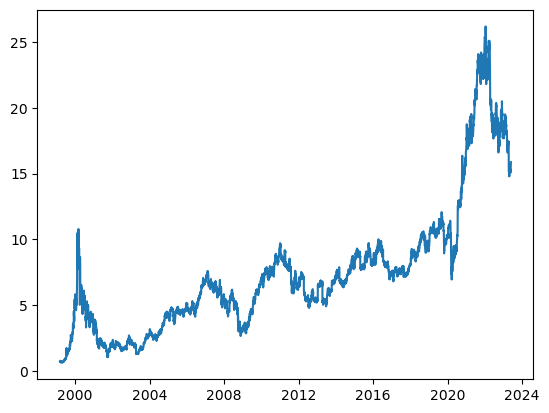

In [10]:
plt.plot(df.index,df['Close'])

In [13]:
temp=df['Volume'].to_numpy()
temp=temp[3:]

6091


In [47]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  ret_df['Target'] = Y
  Z=(df['Volume'].to_numpy())
  l=len(ret_df['Target'])
  Z=Z[len(Z)-l:]
  print(l,' ',len(Z))
  ret_df['volume']=Z
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                # '1999-03-16',
                                '2021-03-27', 
                                '2023-05-26', 
                                n=3)
windowed_df

546   546


,Target Date,Target,volume,Target-3,Target-2,Target-1
0,2021-03-27,18.719999,8066300,18.709999,18.660000,18.459999
1,2021-03-30,18.799999,7845100,18.459999,18.719999,18.430000
2,2021-03-31,18.719999,8991400,18.719999,18.430000,18.799999
3,2021-04-01,19.010000,4213100,18.430000,18.799999,18.719999
4,2021-04-05,19.370001,3919100,18.799999,18.719999,19.010000
...,...,...,...,...,...,...
541,2023-05-22,15.650000,10336400,15.190000,15.150000,15.250000
542,2023-05-23,15.530000,7113800,15.150000,15.250000,15.650000
543,2023-05-24,15.560000,6913200,15.250000,15.650000,15.530000
544,2023-05-25,15.660000,9303400,15.650000,15.530000,15.560000


In [43]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates=df_as_np[:,0]
  middle_matrix=df_as_np[:,1:-1]
  X=middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [44]:
dates.shape, X.shape, y.shape

((546,), (546, 4, 1), (546,))

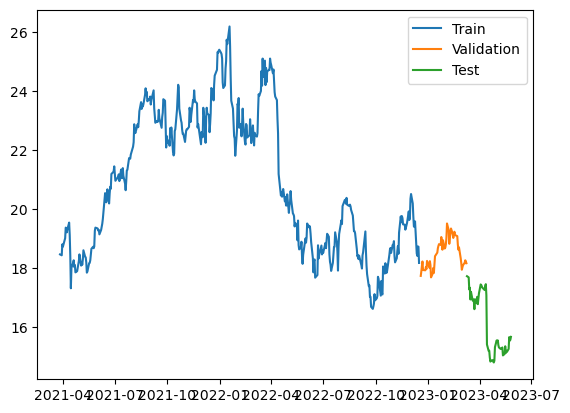

In [45]:
q_80=int(len(dates)*0.8)
q_90=int(len(dates)*0.9)

dates_train,X_train,y_train=dates[:q_80],X[:q_80],y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model=Sequential([
    layers.Dense(32,input_shape=(4,1)),        ## '64' is the number of units(neurons) and is necessary for dense layers
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [49]:
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])

In [50]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
14/14 [==============================] - 2s 36ms/step - loss: 419.1857 - mean_absolute_error: 20.3299 - val_loss: 286.5355 - val_mean_absolute_error: 16.9203
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 335.8543 - mean_absolute_error: 18.1618 - val_loss: 204.6084 - val_mean_absolute_error: 14.2959
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 237.5516 - mean_absolute_error: 15.2132 - val_loss: 118.0104 - val_mean_absolute_error: 10.8523
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 128.1374 - mean_absolute_error: 10.9868 - val_loss: 29.3025 - val_mean_absolute_error: 5.3906
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 32.8108 - mean_absolute_error: 4.9377 - val_loss: 1.2032 - val_mean_absolute_error: 0.9794
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 6.6284 - mean_absolute_error: 2.2372 - val_loss: 14.4007 - val_mean_absolute_error: 3.

14/14 [==============================] - 0s 4ms/step


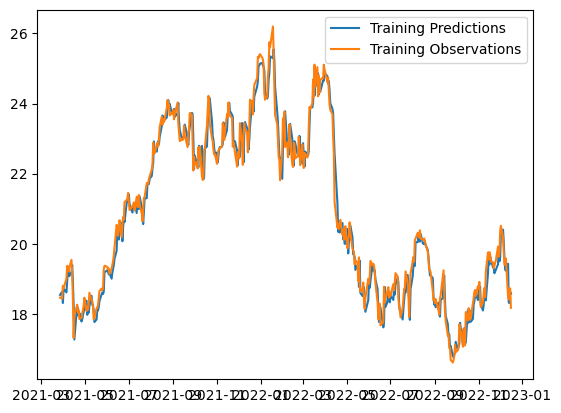

In [51]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


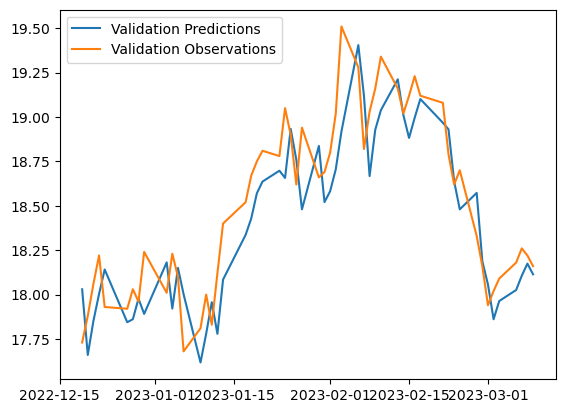

In [52]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 5ms/step


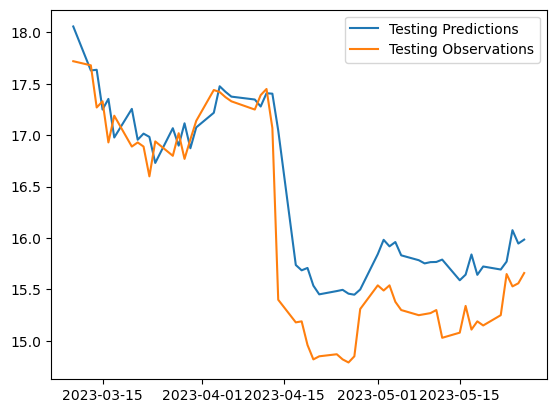

In [53]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

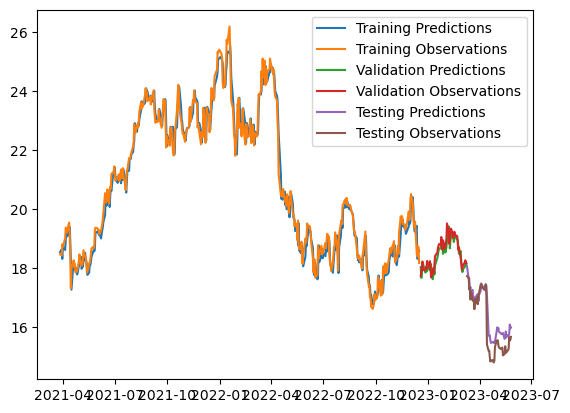

In [54]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])